# Exploring LSTM models 

In this notebook we run lstm models on Infodengue data.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
#os.chdir("..")

from lstm import *
#plot_predicted_vs_data, loss_and_metrics, evaluate, calculate_metrics, train_evaluate_model, 
#from infodenguepredict.models.deeplearning.preprocessing import *
#from infodenguepredict.models.deeplearning.lstm import lstm.build_model
#try:
#    from infodenguepredict.models.deeplearning.lstm import *
#except Exception as e:
#    print(e)

import pickle

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import TensorBoard, EarlyStopping
from keras import backend as K
from sklearn.metrics import *

from time import time

Using TensorFlow backend.


## Loading the data

To download the data we follow the instructions in the [README.rst](https://github.com/fccoelho/InfoDenguePredict/blob/master/README.rst) file.

We perform our experiments on data from Rio de Janeiro. Let us first read all our data.

In [45]:
data_cluster = pd.read_csv("~/data/infodengue/3304557_cluster.csv",index_col=0)
data_cluster.head()

,casos_3306206,casos_est_3306206,casos_est_min_3306206,casos_est_max_3306206,p_rt1_3306206,p_inc100k_3306206,temp_min_3306206,temp_max_3306206,umid_min_3306206,pressao_min_3306206,...,casos_3300456,casos_est_3300456,casos_est_min_3300456,casos_est_max_3300456,p_rt1_3300456,p_inc100k_3300456,temp_min_3300456,temp_max_3300456,umid_min_3300456,pressao_min_3300456
2010-01-03,1,1.0,1,1,0.0,2.80725,24.333333,33.000000,42.000000,1009.666667,...,3,3.0,3,3,0.0,0.607114,24.333333,33.000000,42.000000,1009.666667
2010-01-10,0,0.0,0,0,0.0,0.00000,25.428571,34.000000,43.285714,1008.000000,...,6,6.0,6,6,0.0,1.214230,25.428571,34.000000,43.285714,1008.000000
2010-01-17,0,0.0,0,0,0.0,0.00000,24.142857,34.000000,43.857143,1010.285714,...,1,1.0,1,1,0.0,0.202371,24.142857,34.000000,43.857143,1010.285714
2010-01-24,0,0.0,0,0,0.0,0.00000,23.714286,34.285714,39.285714,1009.000000,...,4,4.0,4,4,0.0,0.809486,23.714286,34.285714,39.285714,1009.000000
2010-01-31,0,0.0,0,0,0.0,0.00000,23.857143,33.857143,41.285714,1009.857143,...,9,9.0,9,9,0.0,1.821340,23.857143,33.857143,41.285714,1009.857143


The city of Rio is coded as cluster `3304557`. We cn easily filter the dataframe above to get only the data corresponding to this cluster.

In [46]:
data_cluster.tail()

,casos_3306206,casos_est_3306206,casos_est_min_3306206,casos_est_max_3306206,p_rt1_3306206,p_inc100k_3306206,temp_min_3306206,temp_max_3306206,umid_min_3306206,pressao_min_3306206,...,casos_3300456,casos_est_3300456,casos_est_min_3300456,casos_est_max_3300456,p_rt1_3300456,p_inc100k_3300456,temp_min_3300456,temp_max_3300456,umid_min_3300456,pressao_min_3300456
2019-04-14,3,3.0,3,3,0.123280,8.42176,23.428571,25.285714,85.986071,1012.857143,...,4,4.0,4,4,0.015841,0.809486,23.428571,25.285714,85.986071,1012.857143
2019-04-21,3,3.0,3,3,0.173497,8.42176,22.571429,25.571429,76.046814,1011.857143,...,0,0.0,0,0,0.000000,0.000000,22.571429,25.571429,76.046814,1011.857143
2019-04-28,11,12.0,11,13,0.958076,33.68700,23.857143,26.857143,78.433171,1013.428571,...,0,0.0,0,0,0.000000,0.000000,23.857143,26.857143,78.433171,1013.428571
2019-05-05,15,20.0,16,21,0.995579,56.14510,23.142857,25.857143,80.172271,1013.000000,...,0,0.0,0,0,0.000000,0.000000,23.142857,25.857143,80.172271,1013.000000
2019-05-12,8,14.0,10,15,0.734682,39.30160,22.142857,24.857143,77.838957,1014.000000,...,0,0.0,0,0,0.000000,0.000000,22.142857,24.857143,77.838957,1014.000000


In [47]:
cluster_rj = data_cluster[[c for c in data_cluster.columns if "3304557" in c.split("_")]]
print(cluster_rj.shape)
print(cluster_rj.columns)
cluster_rj.head()

(488, 10)
Index(['casos_3304557', 'casos_est_3304557', 'casos_est_min_3304557',
       'casos_est_max_3304557', 'p_rt1_3304557', 'p_inc100k_3304557',
       'temp_min_3304557', 'temp_max_3304557', 'umid_min_3304557',
       'pressao_min_3304557'],
      dtype='object')


,casos_3304557,casos_est_3304557,casos_est_min_3304557,casos_est_max_3304557,p_rt1_3304557,p_inc100k_3304557,temp_min_3304557,temp_max_3304557,umid_min_3304557,pressao_min_3304557
2010-01-03,30,30.0,30,30,0.0,0.461621,24.333333,33.000000,42.000000,1009.666667
2010-01-10,46,46.0,46,46,0.0,0.707819,25.428571,34.000000,43.285714,1008.000000
2010-01-17,30,30.0,30,30,0.0,0.461621,24.142857,34.000000,43.857143,1010.285714
2010-01-24,51,51.0,51,51,0.0,0.784756,23.714286,34.285714,39.285714,1009.000000
2010-01-31,58,58.0,58,58,0.0,0.892467,23.857143,33.857143,41.285714,1009.857143


Our goal is to predict the first column, `casos_3304557` from the columns `p_rt1_3304557`, `p_inc100k_3304557`, `temp_min_3304557`, `temp_max_3304557`, `umid_min_3304557`, `pressao_min_3304557`.

In [48]:
usecols = ['casos_3304557', 'p_rt1_3304557', 'p_inc100k_3304557',
       'temp_min_3304557', 'temp_max_3304557', 'umid_min_3304557',
       'pressao_min_3304557']
data = cluster_rj[usecols]
timestamps = pd.to_datetime(data.index)
data.head()


,casos_3304557,p_rt1_3304557,p_inc100k_3304557,temp_min_3304557,temp_max_3304557,umid_min_3304557,pressao_min_3304557
2010-01-03,30,0.0,0.461621,24.333333,33.000000,42.000000,1009.666667
2010-01-10,46,0.0,0.707819,25.428571,34.000000,43.285714,1008.000000
2010-01-17,30,0.0,0.461621,24.142857,34.000000,43.857143,1010.285714
2010-01-24,51,0.0,0.784756,23.714286,34.285714,39.285714,1009.000000
2010-01-31,58,0.0,0.892467,23.857143,33.857143,41.285714,1009.857143


In [49]:
timestamps

DatetimeIndex(['2010-01-03', '2010-01-10', '2010-01-17', '2010-01-24',
               '2010-01-31', '2010-02-07', '2010-02-14', '2010-02-21',
               '2010-02-28', '2010-03-07',
               ...
               '2019-03-10', '2019-03-17', '2019-03-24', '2019-03-31',
               '2019-04-07', '2019-04-14', '2019-04-21', '2019-04-28',
               '2019-05-05', '2019-05-12'],
              dtype='datetime64[ns]', length=488, freq=None)

Let us plot the features of our dataset.

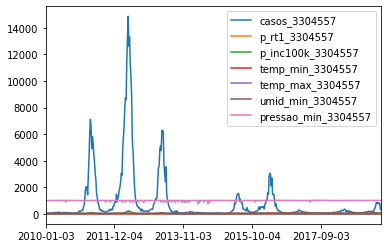

In [50]:
data.plot()

## Normalizing and splitting train/tests sets

In [51]:
### Normalizing data
min_values = np.min(data,axis=0)
max_values = np.max(data,axis=0)
data, _ = normalize_data(data)
data.index=timestamps
data.head()

,casos_3304557,p_rt1_3304557,p_inc100k_3304557,temp_min_3304557,temp_max_3304557,umid_min_3304557,pressao_min_3304557
2010-01-03,0.002018,0.0,0.002018,0.920721,0.891892,0.488451,0.982712
2010-01-10,0.003094,0.0,0.003094,0.962162,0.918919,0.503404,0.981090
2010-01-17,0.002018,0.0,0.002018,0.913514,0.918919,0.510049,0.983315
2010-01-24,0.003430,0.0,0.003430,0.897297,0.926641,0.456885,0.982063
2010-01-31,0.003901,0.0,0.003901,0.902703,0.915058,0.480144,0.982898


In [35]:
max_values

casos_3304557          14868.000000
p_rt1_3304557              1.000000
p_inc100k_3304557        228.779000
temp_min_3304557          26.428571
temp_max_3304557          37.000000
umid_min_3304557          85.986071
pressao_min_3304557     1027.428571
dtype: float64

In [36]:
min_values

casos_3304557           17.000000
p_rt1_3304557            0.000000
p_inc100k_3304557        0.261585
temp_min_3304557        14.285714
temp_max_3304557        17.714286
umid_min_3304557        20.428571
pressao_min_3304557    752.714286
dtype: float64

In [37]:
np.min(data,axis=0)

casos_3304557          0.001143
p_rt1_3304557          0.000000
p_inc100k_3304557      0.001143
temp_min_3304557       0.540541
temp_max_3304557       0.478764
umid_min_3304557       0.237580
pressao_min_3304557    0.732620
dtype: float64

In [39]:
np.min(data,axis=0).iloc[0]*max_values.iloc[0]

17.0

In [10]:
data.index = timestamps

In [11]:
data.index

DatetimeIndex(['2010-01-03', '2010-01-10', '2010-01-17', '2010-01-24',
               '2010-01-31', '2010-02-07', '2010-02-14', '2010-02-21',
               '2010-02-28', '2010-03-07',
               ...
               '2019-03-10', '2019-03-17', '2019-03-24', '2019-03-31',
               '2019-04-07', '2019-04-14', '2019-04-21', '2019-04-28',
               '2019-05-05', '2019-05-12'],
              dtype='datetime64[ns]', length=488, freq=None)

In [12]:
### Splitting train/test sets
X_train, y_train, X_test, y_test = split_data(data, look_back=10, ratio=0.5, predict_n=1, Y_column=0)
#timestamps_train = 

train size:  234


We are looking back 10 weeks to get our training data:

In [13]:
X_train.shape

(234, 10, 7)

In [14]:
X_test.shape

(244, 10, 7)

In [15]:
y_train.shape

(234, 1)

In [16]:
y_test.shape

(244, 1)

## LSTM model
An LSTM model can be retrieved from `lstm.py`.

In [17]:
model = build_model(hidden=4, features=7, predict_n=1, look_back=10, batch_size=39)

W0804 19:00:13.396697 139849924245248 deprecation_wrapper.py:119] From /home/rio/anaconda3/envs/infodengue/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 19:00:13.409557 139849924245248 deprecation_wrapper.py:119] From /home/rio/anaconda3/envs/infodengue/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 19:00:13.412665 139849924245248 deprecation_wrapper.py:119] From /home/rio/anaconda3/envs/infodengue/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0804 19:00:13.451617 139849924245248 deprecation.py:506] From /home/rio/anaconda3/envs/infodengue/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.

Compilation Time :  0.03417611122131348
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (39, 10, 7)               0         
_________________________________________________________________
lstm_1 (LSTM)                (39, 10, 4)               192       
_________________________________________________________________
dropout_1 (Dropout)          (39, 10, 4)               0         
_________________________________________________________________
lstm_2 (LSTM)                (39, 10, 4)               144       
_________________________________________________________________
dropout_2 (Dropout)          (39, 10, 4)               0         
_________________________________________________________________
lstm_3 (LSTM)                (39, 4)                   144       
_________________________________________________________________
dropout_3 (Dropout)          (39, 4)

### Training model

In [18]:
hist = train(model, X_train, y_train, batch_size=1, epochs=20, geocode=None, overwrite=True)

/home/rio/geomed/Analysis/lstm.py:173: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  callbacks=[TB_callback, es, cp]
W0804 19:00:15.826693 139849924245248 deprecation.py:323] From /home/rio/anaconda3/envs/infodengue/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0804 19:00:16.329420 139849924245248 deprecation_wrapper.py:119] From /home/rio/anaconda3/envs/infodengue/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 198 samples, validate on 36 samples


W0804 19:00:16.811529 139849924245248 deprecation_wrapper.py:119] From /home/rio/anaconda3/envs/infodengue/lib/python3.7/site-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0804 19:00:16.811996 139849924245248 deprecation_wrapper.py:119] From /home/rio/anaconda3/envs/infodengue/lib/python3.7/site-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/20
198/198 [==============================] - 7s 36ms/step - loss: 0.0220 - acc: 0.0000e+00 - mean_absolute_percentage_error: 607.5118 - mean_squared_error: 0.0377 - val_loss: 0.0041 - val_acc: 0.0000e+00 - val_mean_absolute_percentage_error: 1338.9030 - val_mean_squared_error: 0.0044
Epoch 2/20
198/198 [==============================] - 6s 31ms/step - loss: 0.0174 - acc: 0.0000e+00 - mean_absolute_percentage_error: 483.5889 - mean_squared_error: 0.0309 - val_loss: 0.0016 - val_acc: 0.0000e+00 - val_mean_absolute_percentage_error: 719.4734 - val_mean_squared_error: 0.0018
Epoch 3/20
198/198 [==============================] - 4s 21ms/step - loss: 0.0118 - acc: 2.5900e-04 - mean_absolute_percentage_error: 288.6654 - mean_squared_error: 0.0217 - val_loss: 0.0014 - val_acc: 0.0000e+00 - val_mean_absolute_percentage_error: 557.0964 - val_mean_squared_error: 0.0015
Epoch 4/20
198/198 [==============================] - 7s 34ms/step - loss: 0.0092 - acc: 3.8850e-04 - mean_absolute_perc

#### Training history

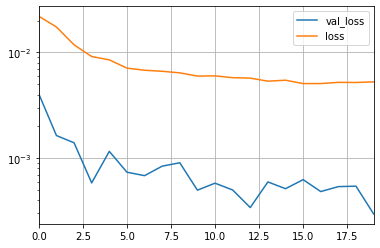

In [19]:
plot_training_history(hist)

#### Plotting predictions 

Compilation Time :  0.025165081024169922
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (478, 10, 7)              0         
_________________________________________________________________
lstm_25 (LSTM)               (478, 10, 4)              192       
_________________________________________________________________
dropout_25 (Dropout)         (478, 10, 4)              0         
_________________________________________________________________
lstm_26 (LSTM)               (478, 10, 4)              144       
_________________________________________________________________
dropout_26 (Dropout)         (478, 10, 4)              0         
_________________________________________________________________
lstm_27 (LSTM)               (478, 4)                  144       
_________________________________________________________________
dropout_27 (Dropout)         (478, 

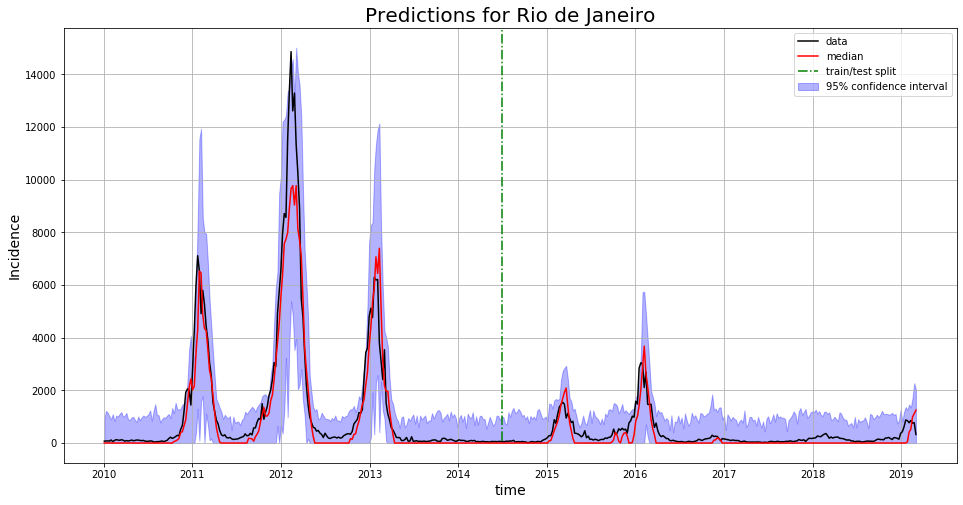

In [52]:
X, y = np.concatenate((X_train,X_test), axis=0), np.concatenate((y_train,y_test),axis=0)*max_values.iloc[0]

timestamps = data.index[:len(X)]
predictions = make_predictions_batch(X, model, hidden=4, features=7, predict_n = 1, look_back=10,\
                                          batch_size=478,n_pred = 100)*max_values.iloc[0]
fig, ax = plt.subplots(figsize=(16,8))
plot_quantiles(ax,timestamps, predictions[:,:,0],y[:,0],\
               axvline_kw={"x": timestamps[len(X_train)], "linestyle": "dashdot", "ymin":0.05,"ymax":1, "color": "g", "label":"train/test split"})
fig.savefig("../figures/LSTM_dropout.png")

## Loading saved model

In [21]:
model = build_model(hidden=4, features=7, predict_n=5, look_back=10, batch_size=38)
#model.compile()
model = load_model("trained_None_model.h5")

Compilation Time :  0.025793075561523438
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (38, 10, 7)               0         
_________________________________________________________________
lstm_13 (LSTM)               (38, 10, 4)               192       
_________________________________________________________________
dropout_13 (Dropout)         (38, 10, 4)               0         
_________________________________________________________________
lstm_14 (LSTM)               (38, 10, 4)               144       
_________________________________________________________________
dropout_14 (Dropout)         (38, 10, 4)               0         
_________________________________________________________________
lstm_15 (LSTM)               (38, 4)                   144       
_________________________________________________________________
dropout_15 (Dropout)         (38, 4

### Plotting results

#### Splitting training, testing sets

In [22]:
cluster = pd.read_csv("~/data/infodengue/3304557_cluster.csv",index_col=0)
cluster.head()
cluster_rj = cluster[[c for c in cluster.columns if "3304557" in c.split("_")]]
usecols = ['casos_3304557', 'p_rt1_3304557', 'p_inc100k_3304557',
       'temp_min_3304557', 'temp_max_3304557', 'umid_min_3304557',
       'pressao_min_3304557']
data = cluster_rj[usecols]
data.head()
### Splitting train/test sets
X_train, y_train, X_test, y_test = split_data(data, look_back=10, ratio=0.8, predict_n=5, Y_column=0)

train size:  380


In [23]:
data

,casos_3304557,p_rt1_3304557,p_inc100k_3304557,temp_min_3304557,temp_max_3304557,umid_min_3304557,pressao_min_3304557
2010-01-03,30,0.000000,0.461621,24.333333,33.000000,42.000000,1009.666667
2010-01-10,46,0.000000,0.707819,25.428571,34.000000,43.285714,1008.000000
2010-01-17,30,0.000000,0.461621,24.142857,34.000000,43.857143,1010.285714
2010-01-24,51,0.000000,0.784756,23.714286,34.285714,39.285714,1009.000000
2010-01-31,58,0.000000,0.892467,23.857143,33.857143,41.285714,1009.857143
2010-02-07,58,0.866734,0.892467,25.142857,37.000000,30.142857,1009.142857
2010-02-14,40,0.115123,0.615495,24.714286,36.428571,29.714286,1008.714286
2010-02-21,62,0.822200,0.954017,24.428571,34.285714,40.142857,1011.000000
2010-02-28,76,0.977246,1.169440,23.285714,32.142857,46.428571,1010.142857
2010-03-07,77,0.928069,1.184830,21.571429,26.428571,69.000000,1010.571429


### Predicting

In [27]:
predictions = make_predictions(model, X_train, n_pred = 100, pred_window = 5, batch_size=38)

In [28]:
type(model)

keras.engine.training.Model

In [29]:
predictions.shape

(100, 380, 5)

[<matplotlib.lines.Line2D at 0x7fce672817b8>,
 <matplotlib.lines.Line2D at 0x7fce67281908>,
 <matplotlib.lines.Line2D at 0x7fce67281a58>,
 <matplotlib.lines.Line2D at 0x7fce67281ba8>,
 <matplotlib.lines.Line2D at 0x7fce67281cf8>]

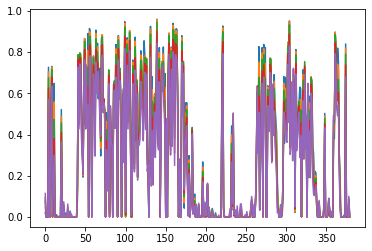

In [30]:
plt.plot(predictions[0])

In [31]:
predictions[0]

array([[ 0.02151161,  0.04732285,  0.0763818 ,  0.09472477,  0.11378736],
       [-0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        ,  0.01131952],
       ...,
       [-0.        , -0.        , -0.        , -0.        , -0.        ],
       [ 0.05351847,  0.06525704,  0.08163858,  0.08883759,  0.10011239],
       [-0.        , -0.        , -0.        , -0.        , -0.        ]],
      dtype=float32)

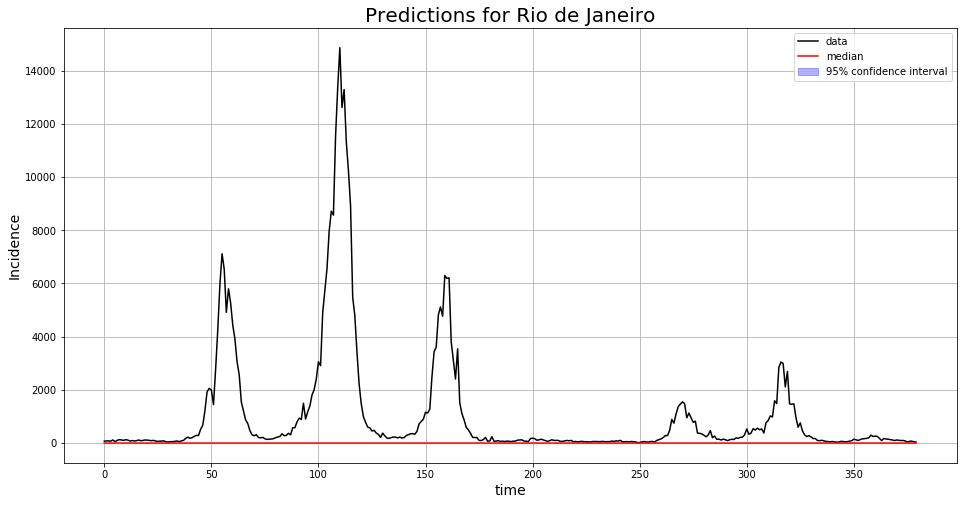

In [32]:
fig, ax = plt.subplots(figsize=(16,8))
plot_quantiles(ax,predictions[:,:,0],y_train[:,0])
fig.savefig("../figures/LSTM_dropout2.png")

In [33]:
for predicted in predictions:
    plot_predicted_vs_data(predicted, y_train, indice, label="Test", pred_window, factor, split_point=None)

SyntaxError: positional argument follows keyword argument (<ipython-input-33-1ad7a905d8a1>, line 2)

In [36]:
predictions[0]

array([[-0.        , -0.        ,  0.01060463,  0.02900201,  0.04632541],
       [-0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ],
       ...,
       [-0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ],
       [ 0.01219941,  0.02530846,  0.03962947,  0.05110162,  0.06248024]],
      dtype=float32)

In [37]:
predictions[1]

array([[-0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        ,  0.01472224],
       [-0.        , -0.        , -0.        , -0.        , -0.        ],
       ...,
       [-0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        ,  0.00654329,  0.01625365]],
      dtype=float32)

In [38]:
len(X_train)

380

In [39]:
len(predictions[0])

380

In [40]:
predictions[2]

array([[-0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ],
       ...,
       [ 0.01433242,  0.01241621,  0.01272241,  0.01129346,  0.01242214],
       [-0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        ,  0.0082344 ]],
      dtype=float32)

In [42]:
predictions

[array([[-0.        , -0.        ,  0.01060463,  0.02900201,  0.04632541],
        [-0.        , -0.        , -0.        , -0.        , -0.        ],
        [-0.        , -0.        , -0.        , -0.        , -0.        ],
        ...,
        [-0.        , -0.        , -0.        , -0.        , -0.        ],
        [-0.        , -0.        , -0.        , -0.        , -0.        ],
        [ 0.01219941,  0.02530846,  0.03962947,  0.05110162,  0.06248024]],
       dtype=float32),
 array([[-0.        , -0.        , -0.        , -0.        , -0.        ],
        [-0.        , -0.        , -0.        , -0.        ,  0.01472224],
        [-0.        , -0.        , -0.        , -0.        , -0.        ],
        ...,
        [-0.        , -0.        , -0.        , -0.        , -0.        ],
        [-0.        , -0.        , -0.        , -0.        , -0.        ],
        [-0.        , -0.        , -0.        ,  0.00654329,  0.01625365]],
       dtype=float32),
 array([[-0.        , -0.        , -0.        , -0.        , -0.        ],
        [-0.        , -0.        , -0.        , -0.        , -0.        ],
        [-0.        , -0.        , -0.        , -0.        , -0.        ],
        ...,
        [ 0.01433242,  0.01241621,  0.01272241,  0.01129346,  0.01242214],
        [-0.        , -0.        , -0.        , -0.        , -0.        ],
        [-0.        , -0.        , -0.        , -0.        ,  0.0082344 ]],
       dtype=float32),
 array([[ 0.00888246,  0.01928994,  0.03117904,  0.04067488,  0.05095193],
        [ 0.0116157 ,  0.00583328,  0.00361965,  0.00031822,  0.00083601],
        [ 0.00083207,  0.00917634,  0.01910677,  0.02720717,  0.03670706],
        ...,
        [-0.        , -0.        , -0.        , -0.        , -0.        ],
        [-0.        , -0.        , -0.        , -0.        , -0.        ],
        [-0.        , -0.        , -0.        , -0.        , -0.        ]],
       dtype=float32),
 array([[-0.        , -0.        , -0.        , -0.        , -0.        ],
        [-0.        , -0.        , -0.        , -0.        , -0.        ],
        [-0.        , -0.        ,  0.00193483,  0.01279879,  0.02489105],
        ...,
        [-0.        , -0.        , -0.        , -0.        , -0.        ],
        [-0.        , -0.        , -0.        , -0.        , -0.        ],
        [-0.        , -0.        , -0.        , -0.        , -0.        ]],
       dtype=float32),
 array([[ 0.02407556,  0.02138408,  0.02208378,  0.02080152,  0.02227297],
        [-0.        , -0.        , -0.        , -0.        ,  0.01070866],
        [ 0.04588871,  0.04527723,  0.04784441,  0.04719872,  0.04837231],
        ...,
        [ 0.02653576,  0.00757478, -0.        , -0.        , -0.        ],
        [-0.        , -0.        , -0.        ,  0.00280165,  0.01171239],
        [-0.        , -0.        , -0.        , -0.        , -0.        ]],
       dtype=float32),
 array([[-0.        , -0.        , -0.        , -0.        ,  0.01020382],
        [-0.        ,  0.00130522,  0.01650974,  0.0299588 ,  0.04372854],
        [ 0.00198051,  0.00746623,  0.01517139,  0.0213452 ,  0.02978313],
        ...,
        [-0.        , -0.        , -0.        , -0.        , -0.        ],
        [-0.        , -0.        , -0.        , -0.        , -0.        ],
        [-0.        , -0.        , -0.        , -0.        , -0.        ]],
       dtype=float32),
 array([[ 0.00922951,  0.00712965,  0.00873307,  0.00901533,  0.01215203],
        [-0.        ,  0.00572587,  0.01920808,  0.03083806,  0.04310999],
        [ 0.01123527,  0.00688466,  0.00595532,  0.00409809,  0.00696446],
        ...,
        [ 0.02807596,  0.04173096,  0.0569053 ,  0.06863738,  0.08061186],
        [ 0.04007487,  0.04409126,  0.0509352 ,  0.05434622,  0.05834869],
        [-0.        , -0.        , -0.        , -0.        , -0.        ]],
       dtype=float32),
 array([[-0.        , -0.        , -0.        , -0.        ,  0.00592448],
        [-0.        ,  0.0066

### Plotting predictions

In [67]:
predictions.shape

(100, 380, 5)

In [61]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.chdir("..")

from infodenguepredict.models.deeplearning.lstm import *
#plot_predicted_vs_data, loss_and_metrics, evaluate, calculate_metrics, train_evaluate_model, 
#from infodenguepredict.models.deeplearning.preprocessing import *
#from infodenguepredict.models.deeplearning.lstm import lstm.build_model
#try:
#    from infodenguepredict.models.deeplearning.lstm import *
#except Exception as e:
#    print(e)

import pickle

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import TensorBoard, EarlyStopping
from keras import backend as K
from sklearn.metrics import *

from time import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
def plot_quantiles(ax,predictions,Ydata,plot = "median",confidence=95, \
                   data_kw={"label": "data","color":"black"}, pred_kw = {"color":"red"},\
                  fill_kw={"color":"blue","alpha":0.3,"label": "95% confidence interval"},\
                   title_kw={"label": "Predictions for Rio de Janeiro","fontsize":20},\
                   xlabel_kw = {"xlabel": "time","fontsize":14},\
                   ylabel_kw={"ylabel":"Incidence","fontsize":14},\
                   grid_params={}):
    """
    Plots model predictions
    """
    
    #ax.plot(Ydata,label="data")
    ax.grid(**grid_params)
    ax.plot(Ydata,**data_kw)
    if plot == "median":
        pred_kw["label"] = "median"
        ax.plot(np.percentile(predictions,50,axis=0),**pred_kw)
    elif plot == "mean":
        pred_kw["label"] = "mean"
        ax.plot(np.mean(predictions,axis=0),**pred_kw)
    if confidence is not None:
        delta = (100-confidence)/2
        lower_bound = np.percentile(predictions,delta,axis=0)
        upper_bound = np.percentile(predictions,100-delta,axis=0)
        x = np.arange(len(lower_bound))
        ax.fill_between(x,lower_bound,upper_bound,where=upper_bound>=lower_bound,**fill_kw)
    if title_kw is not None:
        plt.title(**title_kw)
    if xlabel_kw is not None:
        plt.xlabel(**xlabel_kw)
    if ylabel_kw is not None:
        plt.ylabel(**ylabel_kw)
        
    #    ax.fill_between()
    #if fill_between is not None:
    #    ax.plot(np.percentile(predictions,2.5,axis=0))
    #    ax.plot(np.percentile(predictions,2.5,axis=0))
    #    ax.fill
    #    P.fill_between(indice[7:], df_predicted25[df_predicted25.columns[-1]] * factor,
    #               df_predicted975[df_predicted975.columns[-1]] * factor,
    #               color='b', alpha=0.3)
    ax.legend()
    return ax

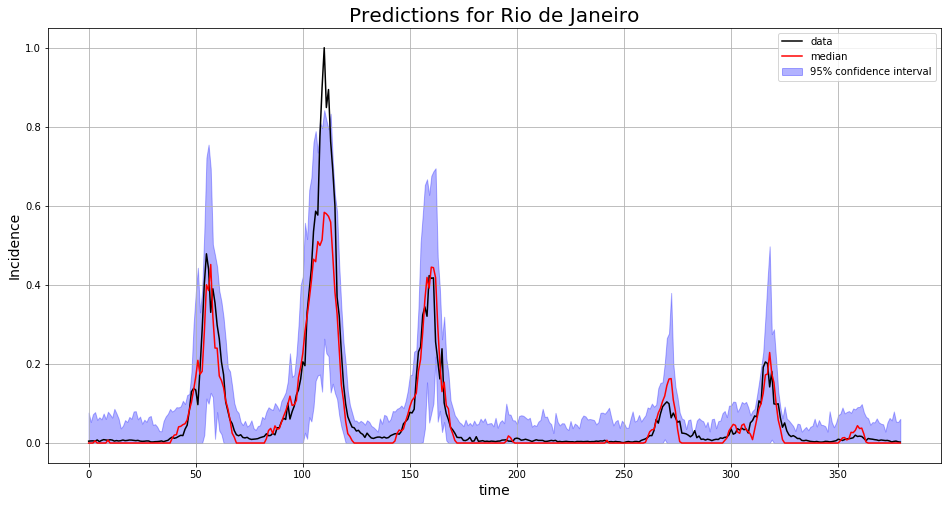

In [119]:
fig, ax = plt.subplots(figsize=(16,8))
plot_quantiles(ax,predictions[:,:,0],y_train[:,0])

In [ ]:
df_predicted = pd.DataFrame(np.percentile(predicted, 50, axis=2))
        df_predicted25 = pd.DataFrame(np.percentile(predicted, 2.5, axis=2))
        df_predicted975 = pd.DataFrame(np.percentile(predicted, 97.5, axis=2))

In [59]:
predictions

[array([[-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [ 8.20091367e-03],
        [ 3.19893584e-02],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [ 3.08459997e-02],
        [ 9.41000879e-04],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [ 2.36300379e-02],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [ 1.93825364e-02],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [ 2.43795440e-02],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [ 1.66173354e-02],
        [-0.00000000e+00],
        [ 5.74201345e-04],
        [-0.00000000e+00],
        [ 2.47427747e-02],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [ 4.92560938e-02],
        [-0.00000000e+00],
        [ 4.10390496e-02],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [ 2.84720957e-02],
        [-0.00000000e+00],
        [ 4.93886322e-02],
        [-0.00000000e+00],
        [ 1.49322227e-02],
        [ 6.42728806e-03],
        [ 2.88125873e-03],
        [ 5.82321808e-02],
        [ 7.41899610e-02],
        [ 1.05698168e-01],
        [ 1.08044073e-01],
        [ 3.05420578e-01],
        [ 1.75079092e-01],
        [ 2.52245724e-01],
        [ 2.40380481e-01],
        [ 1.90073848e-01],
        [ 3.41736436e-01],
        [ 5.45237422e-01],
        [ 1.89662471e-01],
        [ 4.44791794e-01],
        [ 1.98757589e-01],
        [ 2.25243464e-01],
        [ 4.59002972e-01],
        [ 2.34045982e-01],
        [ 2.65122473e-01],
        [ 3.89385484e-02],
        [ 2.35344961e-01],
        [ 1.16437681e-01],
        [ 8.78213271e-02],
        [ 5.84925711e-03],
        [ 8.30421150e-02],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [ 1.23650208e-02],
        [ 2.73513421e-02],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [ 6.93913847e-02],
        [-0.00000000e+00],
        [ 3.30506116e-02],
        [ 5.56354821e-02],
        [ 1.09814778e-02],
        [ 2.92949378e-03],
        [ 3.56326625e-02],
        [ 4.94989753e-02],
        [ 7.08443522e-02],
        [ 7.53046125e-02],
        [ 1.15131050e-01],
        [ 8.59957710e-02],
        [ 1.05568103e-01],
        [ 1.14719771e-01],
        [ 1.24597520e-01],
        [ 9.07422230e-02],
        [ 1.56271935e-01],
        [ 3.37109625e-01],
        [ 5.58216870e-02],
        [ 4.44553375e-01],
        [ 2.87576675e-01],
        [ 3.68659258e-01],
        [ 3.53044569e-01],
        [ 3.05889428e-01],
        [ 3.81618381e-01],
        [ 5.52631378e-01],
        [ 3.06529582e-01],
        [ 1.80047274e-01],
        [ 5.91230869e-01],
        [ 5.53687692e-01],
        [ 8.67630720e-01],
        [ 6.20324850e-01],
        [ 4.69234169e-01],
        [ 3.04262400e-01],
        [ 4.06670511e-01],
        [ 2.57640183e-01],
        [ 1.08260289e-01],
        [ 5.17488196e-02],
        [ 2.14728341e-02],
        [ 3.51333022e-02],
        [ 1.34235695e-02],
        [-0.00000000e+00],
        [ 5.22540510e-03],
        [-0.00000000e+00],
        [ 4.18290496e-03],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [ 6.76839799e-03],
        [-0.00000000e+00],
        [ 4.80229408e-03],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [ 8.90251994e-03],
        [ 7.14077502e-02],
        [ 2.81412601e-02],
        [ 6.97763264e-03],
        [ 5.93624972e-02],
    

In [56]:
predictions[0]

array([[-0.00000000e+00],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [ 8.20091367e-03],
       [ 3.19893584e-02],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [ 3.08459997e-02],
       [ 9.41000879e-04],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [ 2.36300379e-02],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [ 1.93825364e-02],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [ 2.43795440e-02],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [ 1.66173354e-02],
       [-0.00000000e+00],
       [ 5.74201345e-04],
       [-0.00000000e+00],
       [ 2.47427747e-02],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [ 4.92560938e-02],
       [-0.00000000e+00],
       [ 4.10390496e-02],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [ 2.8

In [19]:
hidden = 4
look_back=10
features = 7
batch_size = 38
predict_n = 5

model = Sequential()

model.add(LSTM(hidden,input_shape=(look_back, features),stateful=True, \
batch_input_shape=(batch_size, look_back, features), return_sequences=True,\
dropout=0.2, recurrent_dropout=0.2, implementation=2, unit_forget_bias=True,))
    
model.add(LSTM(hidden,input_shape=(look_back, features),stateful=True, \
batch_input_shape=(batch_size, look_back, features), return_sequences=True, activation='relu',\
dropout=0.2, recurrent_dropout=0.2, implementation=2, unit_forget_bias=True,))

model.add(LSTM(hidden,input_shape=(look_back, features),stateful=True, \
batch_input_shape=(batch_size, look_back, features), return_sequences=False, activation='relu',\
dropout=0.2, recurrent_dropout=0.2, implementation=2, unit_forget_bias=True,))

model.add(Dense(units=predict_n, activation="relu", kernel_initializer="random_uniform",\
                bias_initializer="zeros",))

start = time()
model.compile(loss="msle", optimizer="nadam", metrics=["accuracy", "mape", "mse"])
print("Compilation Time : ", time() - start)
#plot_model(model, to_file="LSTM_model.png")
print(model.summary())



Compilation Time :  0.028424739837646484
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (38, 10, 4)               192       
_________________________________________________________________
lstm_5 (LSTM)                (38, 10, 4)               144       
_________________________________________________________________
lstm_6 (LSTM)                (38, 4)                   144       
_________________________________________________________________
dense_2 (Dense)              (38, 5)                   25        
Total params: 505
Trainable params: 505
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
history = model.fit(X_train,y_train,batch_size=batch_size,epochs=10,validation_split=0.1)

Train on 342 samples, validate on 38 samples
Epoch 1/10
342/342 [==============================] - 2s 6ms/step - loss: 0.0180 - acc: 0.1784 - mean_absolute_percentage_error: 101.9271 - mean_squared_error: 0.0291 - val_loss: 1.3126e-04 - val_acc: 0.1842 - val_mean_absolute_percentage_error: 209.6487 - val_mean_squared_error: 1.3443e-04
Epoch 2/10
342/342 [==============================] - 0s 410us/step - loss: 0.0165 - acc: 0.1170 - mean_absolute_percentage_error: 257.3572 - mean_squared_error: 0.0271 - val_loss: 0.0012 - val_acc: 0.2105 - val_mean_absolute_percentage_error: 586.7501 - val_mean_squared_error: 0.0012
Epoch 3/10
342/342 [==============================] - 0s 469us/step - loss: 0.0159 - acc: 0.2281 - mean_absolute_percentage_error: 456.9268 - mean_squared_error: 0.0262 - val_loss: 0.0018 - val_acc: 0.1842 - val_mean_absolute_percentage_error: 739.3507 - val_mean_squared_error: 0.0019
Epoch 4/10
342/342 [==============================] - 0s 414us/step - loss: 0.0155 - acc: 0

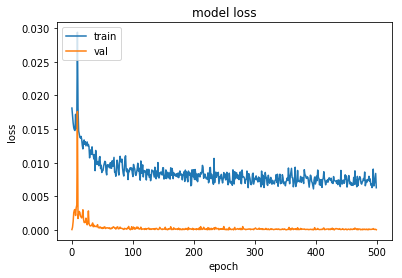

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### LSTM with dropout uncertainty